In [1]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt

from gigalens import *
from gigalens.profiles.light import *
from gigalens.profiles.mass import *

sns.set_style("whitegrid")
tfd = tfp.distributions


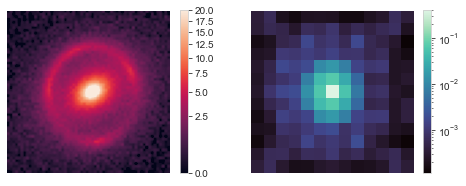

In [2]:
truth = [1.1, 2.0, 0.1, 0.1, 0.1, 0, -0.01, 0.03,
     0.8, 2.5, 0.09534746574143645, 0.14849487967198177, 0.1, 0, 499.3695906504067,
     0.25, 1.5, 0, 0, 0.09566681002252231, -0.0639623054267272, 149.58828877085668
     ]

background_rms = 0.2
exp_time = 100
pixscale = 0.065
image_noisy, kernel = np.load('./assets/demo.npy'), np.load('./assets/psf.npy')
num_pix = len(image_noisy)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(image_noisy, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), origin='lower')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(kernel, norm=mpl.colors.LogNorm(), cmap='mako')
plt.axis('off')
plt.colorbar()

In [3]:
epl = EPL(50)
epl.prior[0] = tfd.LogNormal(tf.math.log(1.25), 0.25)
epl.prior[1] = tfd.TruncatedNormal(2, 0.25, 1, 3)
epl.prior[2] = tfd.Normal(0, 0.1)
epl.prior[3] = tfd.Normal(0, 0.1)
epl.prior[4] = tfd.Normal(0, 0.03)
epl.prior[5] = tfd.Normal(0, 0.03)

shear = Shear()
shear.prior[0] = tfd.Normal(0, 0.05)
shear.prior[1] = tfd.Normal(0, 0.05)

ll = SersicEllipse(use_lstsq=False)
ll.prior[0] = tfd.LogNormal(tf.math.log(1.6), 0.15)
ll.prior[1] = tfd.Uniform(2, 6)
ll.prior[2] = tfd.TruncatedNormal(0, 0.05, -0.15, 0.15)
ll.prior[3] = tfd.TruncatedNormal(0, 0.05, -0.15, 0.15)
ll.prior[4] = tfd.Normal(0, 0.01)
ll.prior[5] = tfd.Normal(0, 0.01)
ll.prior[6] = tfd.LogNormal(tf.math.log(300.), 0.3)

src = SersicEllipse(use_lstsq=False)
src.prior[0] = tfd.LogNormal(tf.math.log(0.25), 0.15)
src.prior[1] = tfd.Uniform(0.5, 4)
src.prior[2] = tfd.TruncatedNormal(0, 0.15, -0.5, 0.5)
src.prior[3] = tfd.TruncatedNormal(0, 0.15, -0.5, 0.5)
src.prior[4] = tfd.Normal(0, 0.25)
src.prior[5] = tfd.Normal(0, 0.25)
src.prior[6] = tfd.LogNormal(tf.math.log(150.), 0.5)
model = Model([epl, shear], [ll], [src])
lensSim = LensSimulator(model, delta_pix=pixscale, num_pix=num_pix, kernel=kernel, supersample=2)


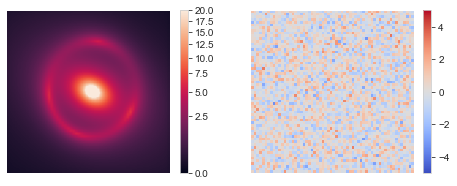

In [5]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lensSim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lensSim.simulate(truth)
resid = simulated - image_noisy
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

In [6]:
fitter = Fitter(model, delta_pix=pixscale, num_pix=num_pix, kernel=kernel, supersample=2, observed_image=image_noisy, background_rms=background_rms, exp_time=exp_time)

In [ ]:
MAP, hist = fitter.MAP(n_samples=500, num_steps=1000, lr0=5e-2, seed=1, lr_reduce_factor=5)

In [ ]:
q_z, losses = fitter.ADVI(MAP, n_vi=1000, num_steps=2000, lr_increase=1e-3/150, lr_max=5e-3)

In [ ]:
samples, mc_results = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, num_burnin_steps=250, num_results=750)